# tree

In [407]:
class Node:
    def __init__(self, index, depth=0):
        self.index = index
        self.depth = depth
        self.left_child = None
        self.right_child = None
        self.left_bound = None
        self.right_bound = None

In [408]:
def breadth_first(root):
 
    current_nodes = [root]
    
    while True:
        
        prev_nodes = current_nodes
        current_nodes = []
        
        for node in prev_nodes:
            print(node.index)
            current_nodes.append(node.left_child)
            current_nodes.append(node.right_child)
        
        if all(node is None for node in current_nodes):
            break

In [409]:
# iterative tree building
def build_tree(root, depth):
    root.index = 0
    current_nodes = [root]
    
    counter = 1

    for i in range(0, depth):
        
        new_nodes = []
        
        for node in current_nodes:
            node.left_child = Node(counter, i+1)
            counter += 1
            node.right_child = Node(counter, i+1)
            counter += 1
            new_nodes.append(node.left_child)
            new_nodes.append(node.right_child)
        
        current_nodes = new_nodes.copy()
        
    return(root)

In [410]:
depth = 3
root = Node(0, 0)
build_tree(root, 3)

In [411]:
root.right_child.right_child.right_child.depth

3

In [412]:
cutpoints = [500, 250, 150, 275, 750, 600, 900]

def depth_first(root, max_depth=10):
 
    if (root == None):
        return
 
    st = []
 
    # start from root node (set current node to root node)
    curr = root
    curr_depth = 0
    # run till stack is not empty or current is
    # not NULL
    while (len(st) or curr != None):
     

        # Print left children while exist
        # and keep appending right into the
        # stack.
        while (curr != None):

            print(curr.index, end = " ")
            cutpoints[curr.index] = cutpoints[curr.index] + 2
            print(f"index:\t{curr.index}\tLB:\t{curr.left_bound}\tRB:\t{curr.right_bound}")
    
            if (curr.right_child != None):
            
                curr.right_child.left_bound = cutpoints[curr.index]
                curr.right_child.right_bound = curr.right_bound
                
                if(curr_depth < max_depth):
                    st.append(curr.right_child)

 
            if (curr.left_child != None):
                curr.left_child.left_bound = curr.left_bound
                curr.left_child.right_bound = cutpoints[curr.index]

            if (curr_depth < max_depth):
                curr = curr.left_child
                curr_depth += 1
            else:
                curr = None

         
        # We reach when curr is NULL, so We
        # take out a right child from stack
        if (len(st) > 0):

            curr = st[-1]
            st.pop()

In [431]:
# Iterative function for inorder tree traversal
def inorder(root, max_depth):
     
    # Set current to root of binary tree
    current = root
    current_depth = 0
    stack = [] # initialize stack
    out = []
     
    while True:
         
        # Reach the left most Node of the current Node
        if current is not None:
             
            # Place pointer to a tree node on the stack
            # before traversing the node's left subtree
            stack.append(current)
            current = current.left_child
            current_depth += 1


        # BackTrack from the empty subtree and visit the Node
        # at the top of the stack; however, if the stack is
        # empty you are done
        elif(stack):
            current = stack.pop()
            
            if current.depth <= max_depth:
                out.append(current)
         
            # We have visited the node and its left
            # subtree. Now, it's right subtree's turn
            current = current.right_child
 
        else:
            break

      
    print()
    return(out)

In [432]:
depth = 3
root = Node(0)
build_tree(root, depth)
# breadth_first(root)
# depth_first(root, 2)
for i in range(0, depth+1):
    out = inorder(root, i)
    print([c.index for c in out])


[0]

[1, 0, 2]

[3, 1, 4, 0, 5, 2, 6]

[7, 3, 8, 1, 9, 4, 10, 0, 11, 5, 12, 2, 13, 6, 14]


# data gen

In [429]:
from scipy.optimize import minimize
import scipy.stats
import torch
import torch.optim as optim
import scipy
# shifted and scaled sigmoid function
def test_sigmoid(x, a=0, b=1.):
    return 1 / (1 + (np.exp(-1 * (x - a) / b)))

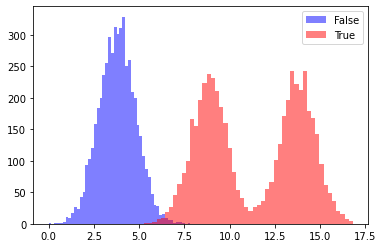

In [430]:
# from cutpoint_model import Model
import numpy as np
import matplotlib.pyplot as plt
from math import exp

N = 10000
P = 5

rs = np.random.RandomState(1978)

X = rs.randn(N, P)
w = rs.randn(P)

y_prob = test_sigmoid(X @ w)
y = (rs.rand(N) < y_prob).astype(int)
t = (rs.randn(N) + 5 * y + (rs.rand(N)> 0.5) * 5 * y )

# make times positive
t += abs(min(t))

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")
plt.legend()
plt.show()

In [662]:
# torch.autograd.set_detect_anomaly(True)
class Model:
    def __init__(self, X, t, sigmoid_temp = 0.01, depth = 1, cutpoint0=None):
        self.X = torch.tensor(X, dtype=torch.float)
        self.t = torch.tensor(t, dtype=torch.float)
        self.t_convert = (self.t - min(self.t)) / (max(self.t) - min(self.t))
        self.sigmoid_temp = sigmoid_temp 
        self.depth = depth

        self.n_cutpoints = 2**(depth+1)-1
        self.theta = []
        for curr_depth in range(0, self.depth+1):
            self.theta.append(
                [torch.zeros( X.shape[1]+1, requires_grad=True).float()]
                * (sum([2**(i) for i in range(0, curr_depth+1)])+1))
#             self.theta.append([torch.zeros( X.shape[1]+1, requires_grad=True).float() for i in range(0,2^(curr_depth)+1)])

#         self.theta = [torch.zeros( X.shape[1]+1, requires_grad=True).float() for i in range(0,self.n_cutpoints)]
        
        self.cutpoint_logit = [torch.tensor(self.logit(torch.tensor(cutpoint)).item(), requires_grad=True) for cutpoint in cutpoint0]
    
        # set up cutpoint tree
        self.root = Node(0)
        root.left_bound = min(self.t)
        root.right_bound = max(self.t)
        self.root = build_tree(root, depth)
        
        
    def logit(self, x):
        return torch.log(x/ (1 - x))
    
    # shifted and scaled sigmoid function
    def sigmoid(self, x, a=0, b=1.):
        return 1 / (1 + (torch.exp(-1 * (x - a) / b)))
    
    
    def pred_value(self, x, theta):
        prod = torch.matmul(x,theta)
        return self.sigmoid(prod)
    
    
    def multinomial_loss(self, thetas, cutpoint_logits):

        
        t_scaled = (self.t - min(self.t)) / (max(self.t) - min(self.t))
        x1 = torch.cat([self.X, torch.ones((len(self.X), 1))], axis=1)

        cutpoints = [self.sigmoid(cp_logit) for cp_logit in cutpoint_logits]
        likelihood = 0
        prior = 0
        
        for lb, rb, theta in zip([0] + cutpoints, cutpoints + [1], thetas):
            left_boundary  = self.sigmoid(t_scaled, lb, self.sigmoid_temp)
            right_boundary = self.sigmoid(t_scaled, rb, self.sigmoid_temp)
        
            p_hat = self.pred_value(x1, theta)
            likelihood += -1 * torch.mean(torch.log(p_hat) * left_boundary * right_boundary)
    
        
        # prior loop
        for lb, curr, rb in zip([0] + cutpoints[:-1], cutpoints, cutpoints[1:] + [1]):
#             print(f"lb:\t{lb}\tcurr:\t{curr}\trb:\t{rb}")
            
            temp = (curr - lb) / (rb - lb)
            prior += -1 * torch.distributions.Beta(torch.tensor(1.5), torch.tensor(1.5)).log_prob(temp)
            
#         print('Likelihood = %.7e | Prior = %.7e' % (likelihood, prior))

        return likelihood + prior
    
    
    def train(self):
        flat_theta = [item for sublist in self.theta for item in sublist]

        optimizer = optim.Adam(flat_theta + self.cutpoint_logit, lr=0.001)
        loss = 0
        loss_layers = [0 for i in range(0, self.depth+1)]
        iteration_num = 1

        ######################################
        # training iteration

        while iteration_num < 1000:

#             if iteration_num % 10 == 0:
#                 print(iteration_num)
                
            #####################################
            # inorder traversal
            for current_depth in range(0, self.depth+1):
                nodes = inorder(self.root, current_depth)
                indices = [node.index for node in nodes]
                current_thetas = self.theta[current_depth]
                current_cutpoints_logit = [self.cutpoint_logit[i] for i in indices]
#                 print(indices)

                loss_layers[current_depth] = self.multinomial_loss(current_thetas, current_cutpoints_logit)
            
            
            # end inorder traversal
            ###################################
            
            loss = sum(loss_layers)
            loss.backward(retain_graph=True)
            optimizer.step()

            # one optimization step
            iteration_num += 1
            
        # end training iteration
        ######################################




In [663]:
depth = 1
root = Node(0)
build_tree(root, depth)
inorder_traversal = inorder(root, depth)
print([c.index for c in inorder_traversal])
equal_spacings = [(i+1)/(2**(depth+1)) for i in range(0, 2**(depth+1) + -1)]
cutpoint0 = [0] * len(inorder_traversal)

for i in range(0, len(inorder_traversal)):
    index = inorder_traversal[i].index
    cutpoint0[index] = equal_spacings[i]

print(cutpoint0)


[1, 0, 2]
[0.5, 0.25, 0.75]


In [664]:
m = Model(X, t, depth = depth, cutpoint0=cutpoint0)


In [665]:
m.train()

In [666]:
cutpoints = [ m.sigmoid(cutpoint) * max(t) for cutpoint in m.cutpoint_logit ]
print(cutpoints)
cutpoints_init = [cutpoint * max(t) for cutpoint in cutpoint0]
print(cutpoints_init)

[tensor(11.4505, grad_fn=<MulBackward0>), tensor(7.7723, grad_fn=<MulBackward0>), tensor(14.3368, grad_fn=<MulBackward0>)]
[8.402695286809909, 4.201347643404954, 12.604042930214863]


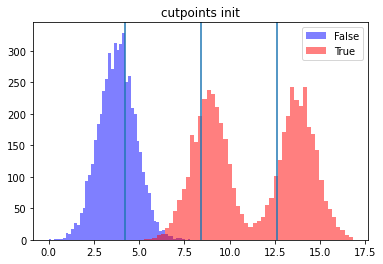

In [667]:
plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")

for cutpoint in cutpoints_init:
    plt.axvline(cutpoint)
    
plt.legend()
plt.title("cutpoints init")
plt.show()

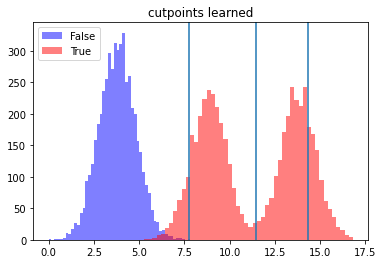

In [668]:
plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")

for cutpoint in cutpoints:
    plt.axvline(cutpoint)
    
plt.legend()
plt.title("cutpoints learned")
plt.show()